# Libraries


In [ ]:
pip install -U albumentations

In [ ]:
!pip install xmltodict

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import glob
import cv2
import os
import zipfile
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from PIL import Image, ImageDraw
from time import sleep
import time

In [ ]:
import xmltodict, json

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data

In [ ]:
zip_file = '/content/drive/MyDrive/data/data.zip'

In [ ]:
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

['.config', 'test_zip', 'train_zip', 'drive', 'sample_data']


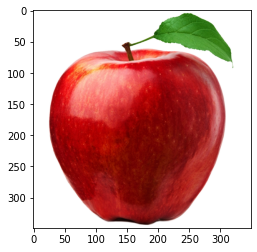

In [ ]:
image = Image.open('./train_zip/train/apple_1.jpg')
image_matrix = np.array(image)
plt.imshow(image_matrix)
plt.show()

First, let's just try to solve the detection problem, without classification

# Detection of one object

In [ ]:
class2tag = {"fruit": 1}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                # labels.append(class2tag[obj["name"]])
                labels.append(class2tag['fruit'])
            # print(labels[1])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )
            # print(bboxes)


    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

## Preprocessing

In [ ]:
from albumentations.augmentations.transforms import Normalize, RandomBrightness, Blur
from albumentations.augmentations import Rotate, RandomSizedBBoxSafeCrop

transform = A.Compose([
                        A.HorizontalFlip(p=0.5),
                        A.Rotate(limit=30, p=0.5),
                        A.RandomSizedBBoxSafeCrop(512, 512, p=0.5),
                        A.Blur(p=0.5),
                        A.RandomBrightness(p=0.5),
                        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
                        ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
train_data = FruitDataset('./train_zip/train', transform)
test_data = FruitDataset('./test_zip/test', transform)

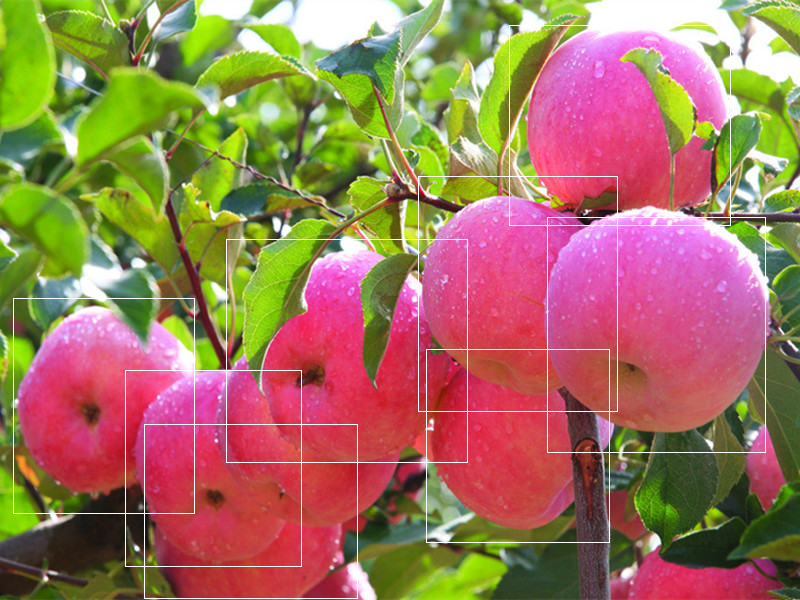

In [ ]:
from PIL import ImageDraw

image, labels = train_data[10]
image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
image

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    # print(iou)
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    # Non Maximum Suppresion
    nms = torchvision.ops.batched_nms(torch.from_numpy(dt_bboxes), torch.from_numpy(dt_scores), torch.from_numpy(dt_labels), 0.1)

    results = []
    for detection_id in nms:
    #for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        dict_loss = model(images, targets) 
        losses = sum(loss for loss in dict_loss.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())
        # print(losses)
        # print(losses.cpu().detach())
        # print(global_loss)

        # print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))
        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, num_epochs, train_loader, test_loader, optimizer, device):
    for epoch in range(num_epochs):
        print("epoch {}/{}..".format(epoch, num_epochs))
        start = time.time()
        train_one_epoch(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)
        end = time.time()

        print("epoch {} done in {}s".format(epoch, round(end - start, 2)))
        print("mAP after epoch {} is {}:".format(epoch, round(mAP, 3)))

In [ ]:
def get_detection_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # print(in_features, num_classes)

    return model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_loader_train = torch.utils.data.DataLoader(
    train_data, batch_size=2, shuffle=True, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    test_data, batch_size=2, shuffle=False, collate_fn=collate_fn)

## Not trained model

In [ ]:
def get_detection_model_not_trained(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # print(in_features, num_classes)

    return model

In [ ]:
num_classes = 2
num_epochs = 5

model = get_detection_model_not_trained(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.000001, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.AdamW(params, lr=0.00001)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
train(model, num_epochs, data_loader_train, data_loader_test, optimizer, device)

epoch 0/5..


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss value after 10 batches is 1.13
Loss value after 20 batches is 0.93
Loss value after 30 batches is 0.83
Loss value after 40 batches is 0.75
Loss value after 50 batches is 0.68
Loss value after 60 batches is 0.63
Loss value after 70 batches is 0.57
Loss value after 80 batches is 0.54
Loss value after 90 batches is 0.52
Loss value after 100 batches is 0.5
Loss value after 110 batches is 0.49
Loss value after 120 batches is 0.48
epoch 0 done in 202.19s
mAP after epoch 0 is 0.467:
epoch 1/5..
Loss value after 10 batches is 0.26
Loss value after 20 batches is 0.25
Loss value after 30 batches is 0.27
Loss value after 40 batches is 0.29
Loss value after 50 batches is 0.3
Loss value after 60 batches is 0.3
Loss value after 70 batches is 0.28
Loss value after 80 batches is 0.27
Loss value after 90 batches is 0.27
Loss value after 100 batches is 0.28
Loss value after 110 batches is 0.28
Loss value after 120 batches is 0.28
epoch 1 done in 206.17s
mAP after epoch 1 is 0.735:
epoch 2/5..
Loss 

As we can see below, a similar model, but pre-trained, gives a noticeably better result.

## Pretrained model

Let's try to train a model with a threshold of IoU = 0.5 and without restrictions on score.

In [ ]:
num_classes = 2
num_epochs = 5

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00001)

In [ ]:
train(model, num_epochs, data_loader_train, data_loader_test, optimizer, device)

epoch 0/5..
Loss value after 10 batches is 0.62
Loss value after 20 batches is 0.52
Loss value after 30 batches is 0.43
Loss value after 40 batches is 0.39
Loss value after 50 batches is 0.37
Loss value after 60 batches is 0.35
Loss value after 70 batches is 0.36
Loss value after 80 batches is 0.35
Loss value after 90 batches is 0.35
Loss value after 100 batches is 0.34
Loss value after 110 batches is 0.33
Loss value after 120 batches is 0.33
epoch 0 done in 194.39s
mAP after epoch 0 is 0.817:
epoch 1/5..
Loss value after 10 batches is 0.28
Loss value after 20 batches is 0.26
Loss value after 30 batches is 0.27
Loss value after 40 batches is 0.25
Loss value after 50 batches is 0.26
Loss value after 60 batches is 0.26
Loss value after 70 batches is 0.26
Loss value after 80 batches is 0.25
Loss value after 90 batches is 0.25
Loss value after 100 batches is 0.24
Loss value after 110 batches is 0.24
Loss value after 120 batches is 0.24
epoch 1 done in 197.08s
mAP after epoch 1 is 0.866:
ep

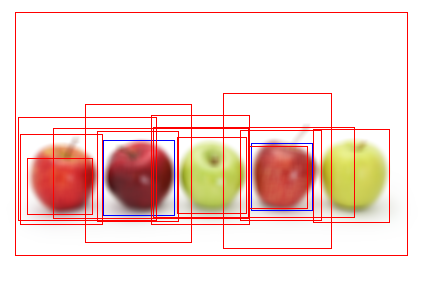

In [ ]:
model.eval()

image, labels = test_data[7]
image
pred = model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Let's see how the metric will be affected by the introduction of a limit on score > 0.5

In [ ]:
num_classes = 2
num_epochs = 5

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00001)

In [ ]:
train(model, num_epochs, data_loader_train, data_loader_test, optimizer, device)

epoch 0/5..
Loss value after 10 batches is 0.47
Loss value after 20 batches is 0.46
Loss value after 30 batches is 0.4
Loss value after 40 batches is 0.39
Loss value after 50 batches is 0.35
Loss value after 60 batches is 0.35
Loss value after 70 batches is 0.34
Loss value after 80 batches is 0.33
Loss value after 90 batches is 0.32
Loss value after 100 batches is 0.31
Loss value after 110 batches is 0.31
Loss value after 120 batches is 0.3
epoch 0 done in 194.41s
mAP after epoch 0 is 0.242:
epoch 1/5..
Loss value after 10 batches is 0.26
Loss value after 20 batches is 0.23
Loss value after 30 batches is 0.21
Loss value after 40 batches is 0.23
Loss value after 50 batches is 0.23
Loss value after 60 batches is 0.22
Loss value after 70 batches is 0.22
Loss value after 80 batches is 0.22
Loss value after 90 batches is 0.21
Loss value after 100 batches is 0.22
Loss value after 110 batches is 0.21
Loss value after 120 batches is 0.22
epoch 1 done in 197.73s
mAP after epoch 1 is 0.256:
epoc

It can be seen that with the introduction of the threshold on score > 0.5, IoU decreased.

Let's train a model with IoU = 0.7

In [ ]:
num_classes = 2
num_epochs = 5

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00001)

In [ ]:
train(model, num_epochs, data_loader_train, data_loader_test, optimizer, device)

epoch 0/5..
Loss value after 10 batches is 1.17
Loss value after 20 batches is 0.86
Loss value after 30 batches is 0.77
Loss value after 40 batches is 0.65
Loss value after 50 batches is 0.57
Loss value after 60 batches is 0.53
Loss value after 70 batches is 0.5
Loss value after 80 batches is 0.47
Loss value after 90 batches is 0.45
Loss value after 100 batches is 0.44
Loss value after 110 batches is 0.42
Loss value after 120 batches is 0.41
epoch 0 done in 195.5s
mAP after epoch 0 is 0.487:
epoch 1/5..
Loss value after 10 batches is 0.34
Loss value after 20 batches is 0.33
Loss value after 30 batches is 0.3
Loss value after 40 batches is 0.28
Loss value after 50 batches is 0.27
Loss value after 60 batches is 0.27
Loss value after 70 batches is 0.26
Loss value after 80 batches is 0.26
Loss value after 90 batches is 0.24
Loss value after 100 batches is 0.24
Loss value after 110 batches is 0.24
Loss value after 120 batches is 0.24
epoch 1 done in 192.8s
mAP after epoch 1 is 0.542:
epoch 

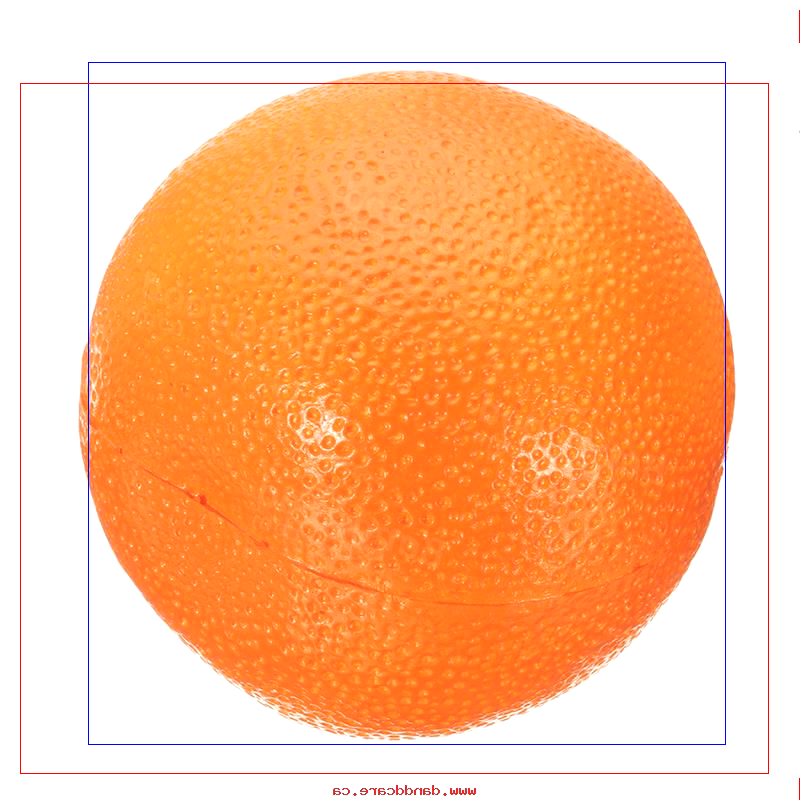

In [ ]:
model.eval()

image, labels = test_data[4]
image
pred = model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

It is also clear that the quality has noticeably deteriorated.

## Non Maximum Suppression

In [ ]:
num_classes = 2
num_epochs = 5

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00001)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
train(model, num_epochs, data_loader_train, data_loader_test, optimizer, device)

epoch 0/5..


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss value after 10 batches is 0.56
Loss value after 20 batches is 0.48
Loss value after 30 batches is 0.43
Loss value after 40 batches is 0.42
Loss value after 50 batches is 0.39
Loss value after 60 batches is 0.38
Loss value after 70 batches is 0.36
Loss value after 80 batches is 0.35
Loss value after 90 batches is 0.35
Loss value after 100 batches is 0.34
Loss value after 110 batches is 0.33
Loss value after 120 batches is 0.32
epoch 0 done in 239.17s
mAP after epoch 0 is 0.677:
epoch 1/5..
Loss value after 10 batches is 0.2
Loss value after 20 batches is 0.2
Loss value after 30 batches is 0.2
Loss value after 40 batches is 0.2
Loss value after 50 batches is 0.21
Loss value after 60 batches is 0.21
Loss value after 70 batches is 0.22
Loss value after 80 batches is 0.21
Loss value after 90 batches is 0.22
Loss value after 100 batches is 0.22
Loss value after 110 batches is 0.23
Loss value after 120 batches is 0.22
epoch 1 done in 235.48s
mAP after epoch 1 is 0.611:
epoch 2/5..
Loss v

KeyboardInterrupt: ignored

As we can see, the value of the metric has decreased, but let's try to look at the algorithm in the pictures.

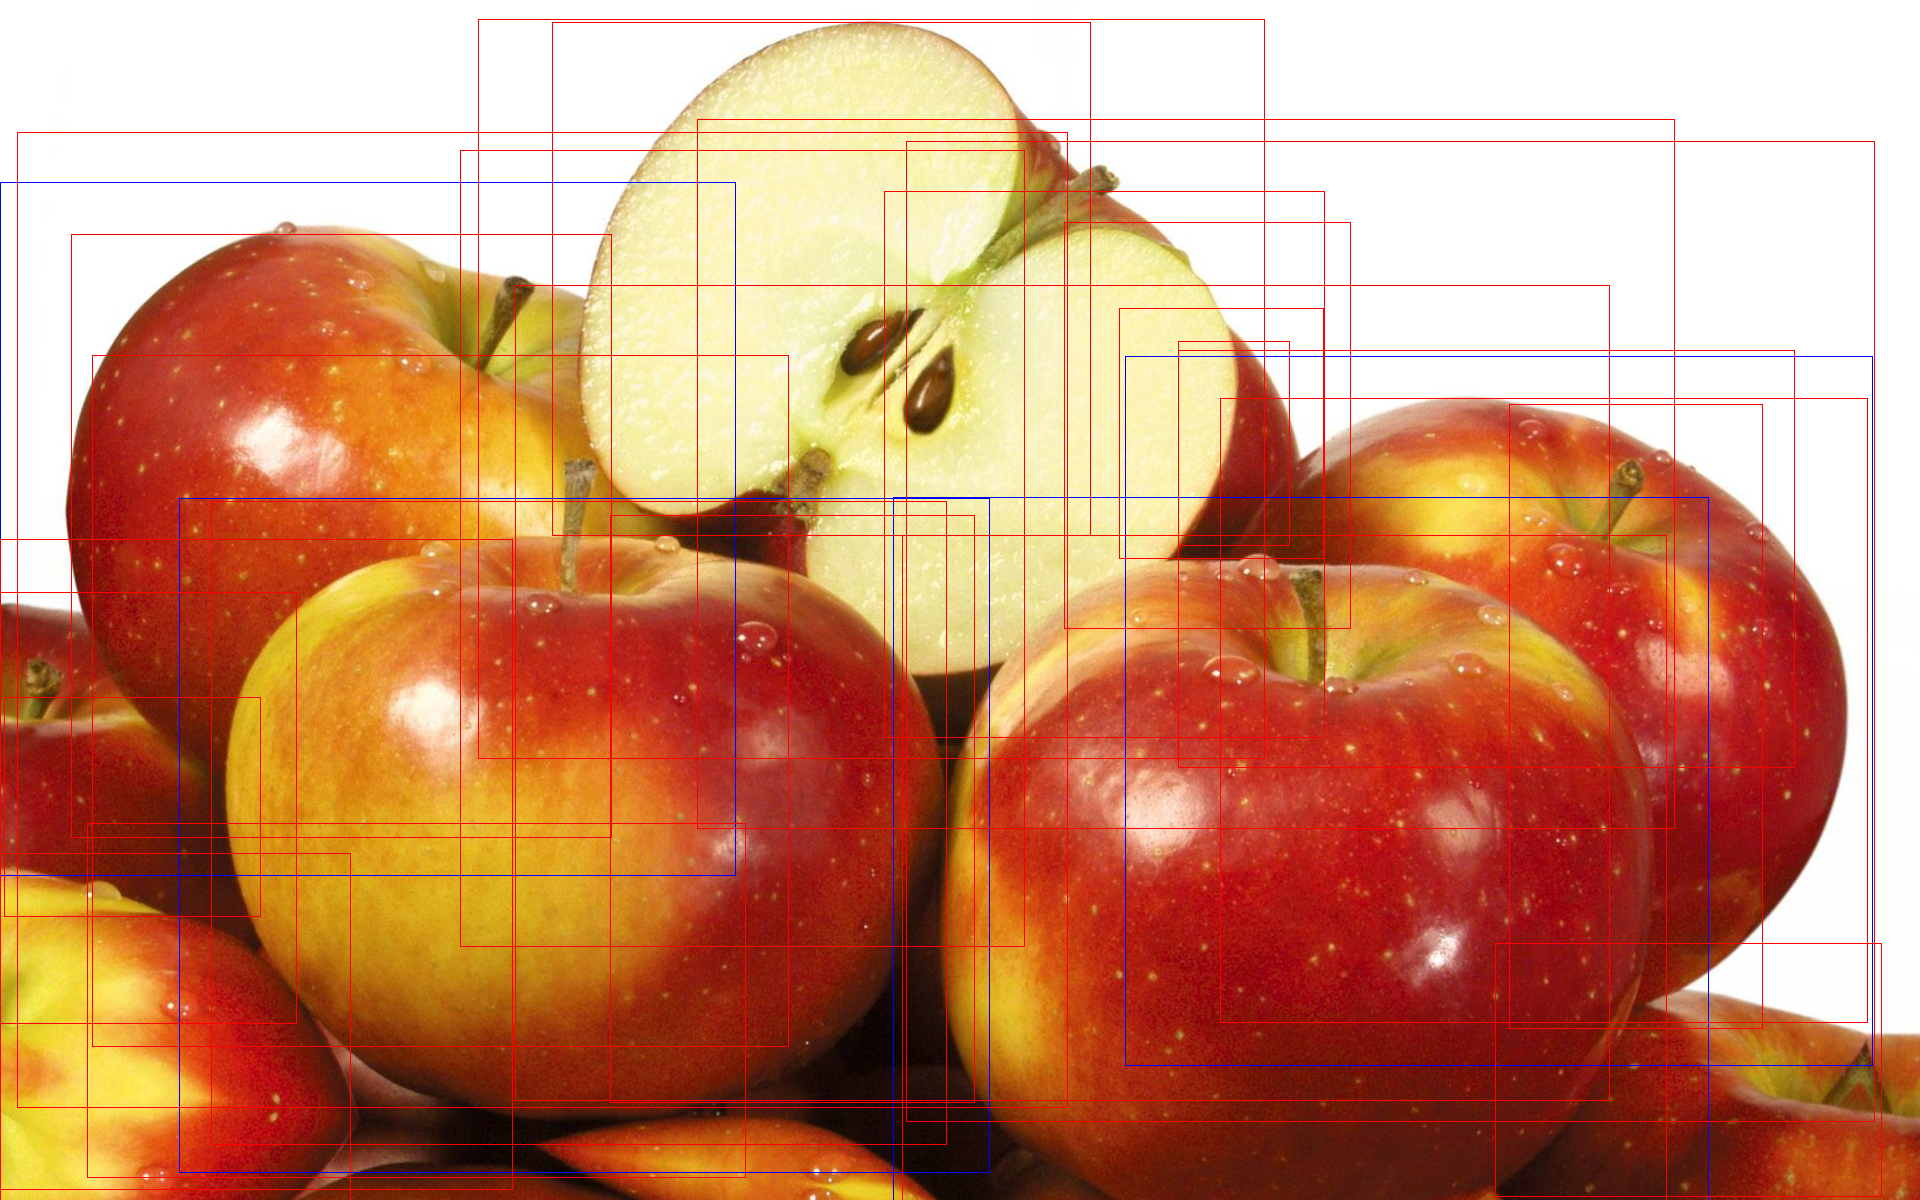

In [ ]:
model.eval()

image, labels = test_data[46]
image
pred = model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

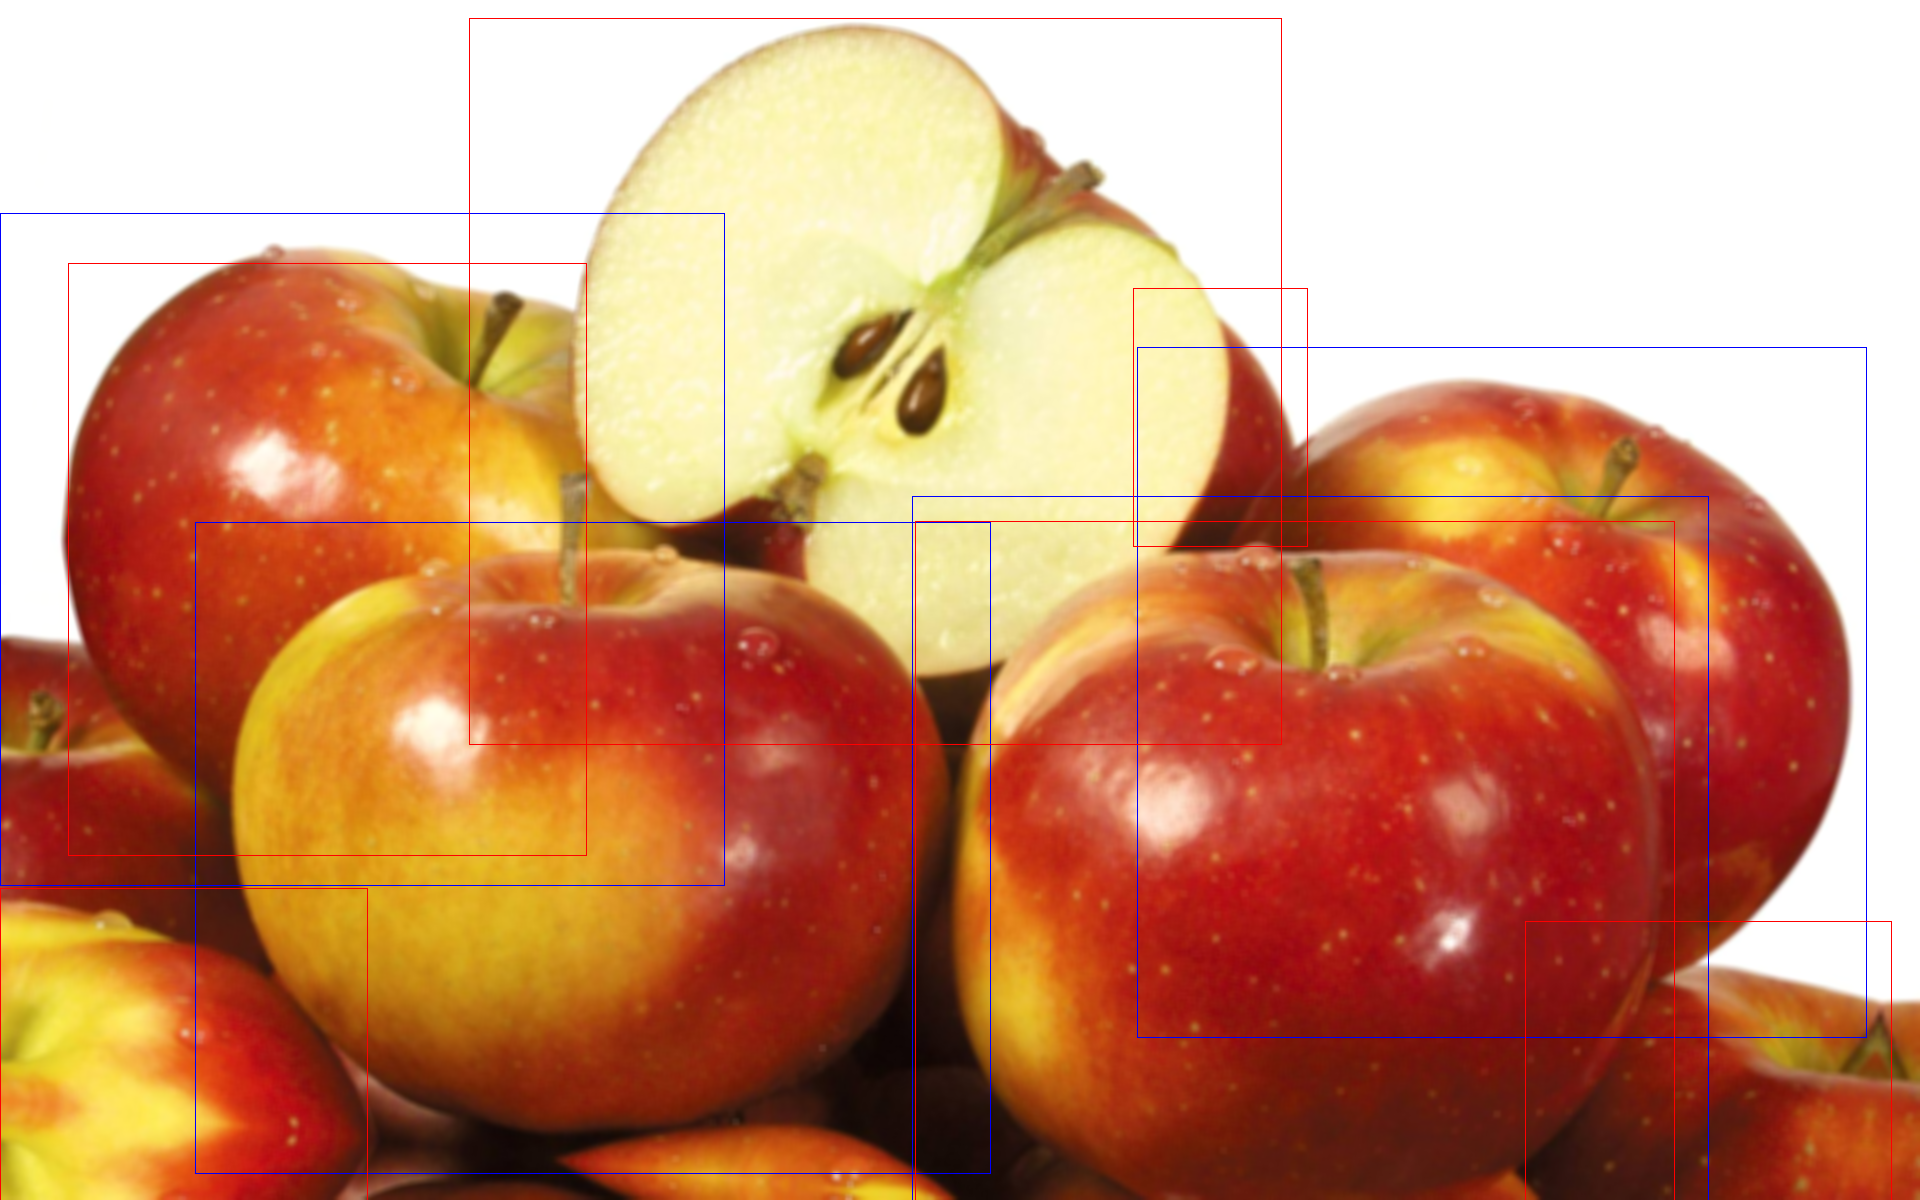

In [ ]:
model.eval()

image, labels = test_data[46]
image
pred = model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

# оставить только определенные индексы
indexes = torchvision.ops.batched_nms(pred['boxes'], pred['scores'], pred['labels'], 0.1)
indexes.detach().cpu().numpy()

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
true_dict = pred['boxes'][indexes]
for box in true_dict:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Let's see how the threshold on score affects the result

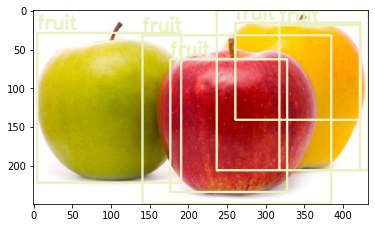

In [ ]:
image = Image.open('/content/drive/MyDrive/data/apples.jpg')

model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0)
image = draw_boxes(boxes, classes, labels, image)
plt.imshow(image)
plt.show()

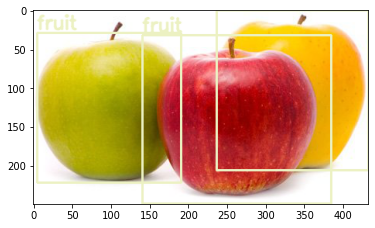

In [ ]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

image = Image.open('/content/drive/MyDrive/data/apples.jpg')

model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0.8) # порог 0.8
image = draw_boxes(boxes, classes, labels, image)
plt.imshow(image)
plt.show()

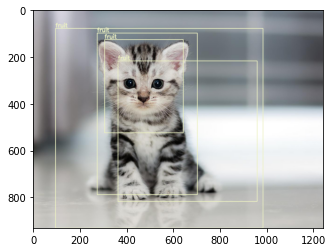

In [ ]:
image = Image.open('/content/drive/MyDrive/data/cat.jpeg')

model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0)
image = draw_boxes(boxes, classes, labels, image)
plt.imshow(image)
plt.show()

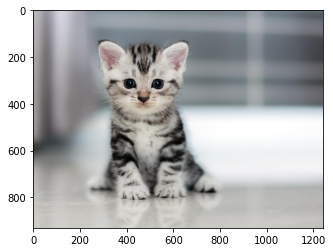

In [ ]:
image = Image.open('/content/drive/MyDrive/data/cat.jpeg')

model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0.8) # порог 0.8
image = draw_boxes(boxes, classes, labels, image)
plt.imshow(image)
plt.show()

It can be seen that the introduction of the threshold also gives an excellent result.

# Detection of multiple different fruits

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    # print(iou)
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.4):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    # Non Maximum Suppresion
    # nms = torchvision.ops.batched_nms(torch.from_numpy(dt_bboxes), torch.from_numpy(dt_scores), torch.from_numpy(dt_labels), 0.1)

    results = []
    #for detection_id in nms:
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        dict_loss = model(images, targets) 
        losses = sum(loss for loss in dict_loss.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())
        # print(losses)
        # print(losses.cpu().detach())
        # print(global_loss)

        # print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))
        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, num_epochs, train_loader, test_loader, optimizer, device):
    for epoch in range(num_epochs):
        print("epoch {}/{}..".format(epoch, num_epochs))
        start = time.time()
        train_one_epoch(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)
        end = time.time()

        print("epoch {} done in {}s".format(epoch, round(end - start, 2)))
        print("mAP after epoch {} is {}:".format(epoch, round(mAP, 3)))

In [ ]:
transform = A.Compose([
                        A.HorizontalFlip(p=0.5),                       
                        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
                        ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
train_data = FruitDataset('./train_zip/train', transform=transform)
test_data = FruitDataset('./test_zip/test', transform=transform)

In [ ]:
data_loader_train = torch.utils.data.DataLoader(
    train_data, batch_size=2, shuffle=True, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    test_data, batch_size=2, shuffle=False, collate_fn=collate_fn)

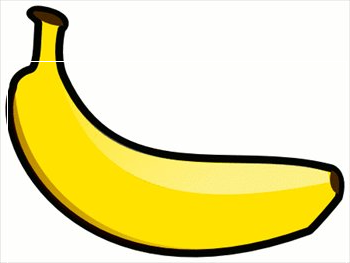

In [ ]:
from PIL import ImageDraw

image, labels = train_data[0]
image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
image

In [ ]:
import torchvision.transforms as transforms

class_names = ['background', 'apple', 'orange', 'banana']

transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
])

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image
    # print the results individually
    # print(f"BOXES: {outputs[0]['boxes']}")
    # print(f"LABELS: {outputs[0]['labels']}")
    # print(f"SCORES: {outputs[0]['scores']}")
    # get all the predicited class names
    pred_classes = [class_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    return boxes, pred_classes, outputs[0]['labels']

COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))

def draw_boxes(boxes, classes, labels, image):
    # read the image with OpenCV
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
      
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
    return image

## Not trained model

In [ ]:
num_classes = 4
num_epochs = 2

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00001)

In [ ]:
train(model, num_epochs, data_loader_train, data_loader_test, optimizer, device)

epoch 0/2..
Loss value after 10 batches is 1.28
Loss value after 20 batches is 0.96
Loss value after 30 batches is 0.85
Loss value after 40 batches is 0.74
Loss value after 50 batches is 0.69
Loss value after 60 batches is 0.65
Loss value after 70 batches is 0.61
Loss value after 80 batches is 0.58
Loss value after 90 batches is 0.57
Loss value after 100 batches is 0.54
Loss value after 110 batches is 0.52
Loss value after 120 batches is 0.5
epoch 0 done in 264.1s
mAP after epoch 0 is 0.559:
epoch 1/2..
Loss value after 10 batches is 0.38
Loss value after 20 batches is 0.35
Loss value after 30 batches is 0.34
Loss value after 40 batches is 0.31
Loss value after 50 batches is 0.31
Loss value after 60 batches is 0.3
Loss value after 70 batches is 0.29
Loss value after 80 batches is 0.29
Loss value after 90 batches is 0.29
Loss value after 100 batches is 0.28
Loss value after 110 batches is 0.28
Loss value after 120 batches is 0.28
epoch 1 done in 265.02s
mAP after epoch 1 is 0.849:


Also, as before, the model accelerates slower, and with a small amount of data, it is more expedient to use the already pre-trained one.

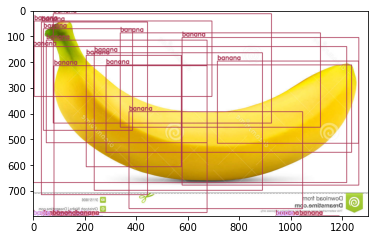

In [ ]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

image = test_data[2][0]
image = T.ToPILImage()(image)
model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0)
image = draw_boxes(boxes, classes, labels, image) 
plt.imshow(image)
plt.show()

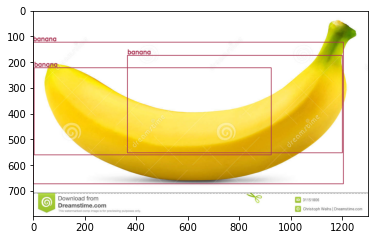

In [ ]:
image = test_data[2][0]
image = T.ToPILImage()(image)
model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0.8)
image = draw_boxes(boxes, classes, labels, image) 
plt.imshow(image)
plt.show()

## Pretrained model

Model with IoU = 0.4

In [ ]:
num_classes = 4
num_epochs = 3

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00001)

## BEST SCORE: 0.934

In [ ]:
train(model, num_epochs, data_loader_train, data_loader_test, optimizer, device)

epoch 0/3..
Loss value after 10 batches is 0.96
Loss value after 20 batches is 0.71
Loss value after 30 batches is 0.64
Loss value after 40 batches is 0.6
Loss value after 50 batches is 0.57
Loss value after 60 batches is 0.55
Loss value after 70 batches is 0.54
Loss value after 80 batches is 0.51
Loss value after 90 batches is 0.5
Loss value after 100 batches is 0.48
Loss value after 110 batches is 0.47
Loss value after 120 batches is 0.45
epoch 0 done in 268.71s
mAP after epoch 0 is 0.805:
epoch 1/3..
Loss value after 10 batches is 0.19
Loss value after 20 batches is 0.24
Loss value after 30 batches is 0.25
Loss value after 40 batches is 0.27
Loss value after 50 batches is 0.26
Loss value after 60 batches is 0.26
Loss value after 70 batches is 0.26
Loss value after 80 batches is 0.27
Loss value after 90 batches is 0.27
Loss value after 100 batches is 0.26
Loss value after 110 batches is 0.27
Loss value after 120 batches is 0.26
epoch 1 done in 265.41s
mAP after epoch 1 is 0.901:
epoc

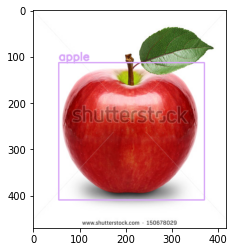

In [ ]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

image = test_data[52][0]
image = T.ToPILImage()(image)
model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0.8)
image = draw_boxes(boxes, classes, labels, image) 
plt.imshow(image)
plt.show()

The model is pretty sure it's an apple

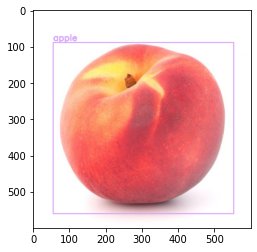

In [ ]:
image = Image.open('/content/drive/MyDrive/data/peach.jpg')

model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0.9)
image = draw_boxes(boxes, classes, labels, image)
plt.imshow(image)
plt.show()

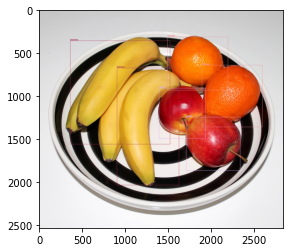

In [ ]:
image = Image.open('/content/drive/MyDrive/data/bowl_fruits.jpg')

model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0.8)
image = draw_boxes(boxes, classes, labels, image)
plt.imshow(image)
plt.show()

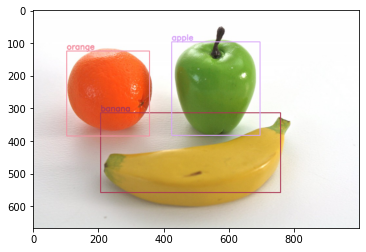

In [ ]:
image = Image.open('/content/drive/MyDrive/data/3-34.jpg')

model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0.8)
image = draw_boxes(boxes, classes, labels, image)
plt.imshow(image)
plt.show()

The model perfectly identified each of the fruits:)

In [ ]:
num_classes = 4
num_epochs = 5

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00001)

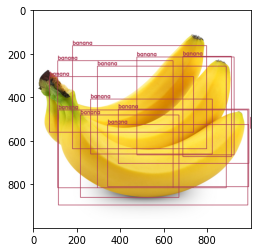

In [ ]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

image = test_data[50][0]
image = T.ToPILImage()(image)
model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0)
image = draw_boxes(boxes, classes, labels, image) 
plt.imshow(image)
plt.show()

Changing of bounding boxes when changing the score threshold:

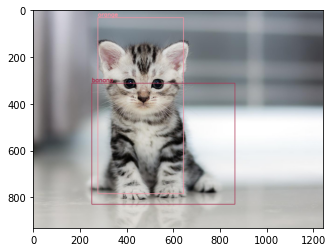

In [ ]:
image = Image.open('/content/drive/MyDrive/data/cat.jpeg')

model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0)
image = draw_boxes(boxes, classes, labels, image)
plt.imshow(image)
plt.show()

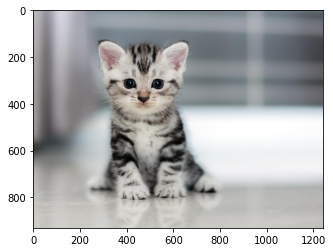

In [ ]:
image = Image.open('/content/drive/MyDrive/data/cat.jpeg')

model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0.8)
image = draw_boxes(boxes, classes, labels, image)
plt.imshow(image)
plt.show()

## NMS

In [ ]:
num_classes = 2
num_epochs = 5

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00001)

In [ ]:
train(model, num_epochs, data_loader_train, data_loader_test, optimizer, device)

epoch 0/3..
Loss value after 10 batches is 1.35
Loss value after 20 batches is 0.98
Loss value after 30 batches is 0.76
Loss value after 40 batches is 0.69
Loss value after 50 batches is 0.66
Loss value after 60 batches is 0.61
Loss value after 70 batches is 0.59
Loss value after 80 batches is 0.56
Loss value after 90 batches is 0.54
Loss value after 100 batches is 0.52
Loss value after 110 batches is 0.51
Loss value after 120 batches is 0.49
epoch 0 done in 263.59s
mAP after epoch 0 is 0.629:
epoch 1/3..
Loss value after 10 batches is 0.31
Loss value after 20 batches is 0.34
Loss value after 30 batches is 0.31
Loss value after 40 batches is 0.28
Loss value after 50 batches is 0.27
Loss value after 60 batches is 0.27
Loss value after 70 batches is 0.28
Loss value after 80 batches is 0.27
Loss value after 90 batches is 0.26
Loss value after 100 batches is 0.27
Loss value after 110 batches is 0.26
Loss value after 120 batches is 0.26
epoch 1 done in 264.92s
mAP after epoch 1 is 0.718:
ep

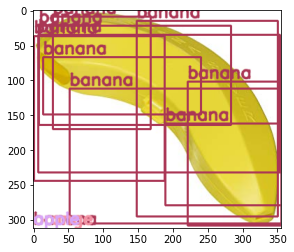

In [ ]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

image = test_data[31][0]
image = T.ToPILImage()(image)
model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0)
image = draw_boxes(boxes, classes, labels, image) 
plt.imshow(image)
plt.show()

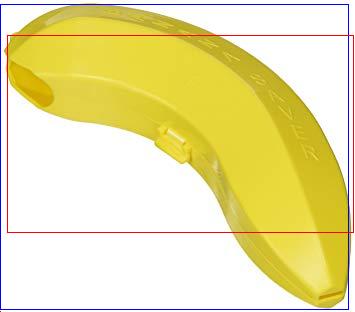

In [ ]:
model.eval()

image, labels = test_data[31]
image
pred = model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

# оставить только определенные индексы
indexes = torchvision.ops.batched_nms(pred['boxes'], pred['scores'], pred['labels'], 0.1)
indexes.detach().cpu().numpy()

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
true_dict = pred['boxes'][indexes]
for box in true_dict:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

A great example of demonstrating the benefits of NMS.

# Conclusion

Without a threshold on score and NMS, it is difficult to determine the best bbox.